In [1]:
import sys
sys.path.append('../')
sys.path.append('old/')

import pylab as pl
import numpy as np
from scipy import rand
import geom_impact_poly as poly
from scipy.constants import e, epsilon_0
import FiniteDifferences_ShortleyWeller_SquareGrid as PIC_FDSW
import FiniteDifferences_Staircase_SquareGrid as PIC_FDSC

import FFT_OpenBoundary_SquareGrid as PIC_FFT
import FFT_PEC_Boundary_SquareGrid as PIC_PEC_FFT


from pypic import PyPIC_Fortran_M2P_P2M, PyPIC
from meshing import RectMesh2D
from poisson_solver import FD_solver as FD
from poisson_solver import FFT_solver as FFT
from poisson_solver.FD_solver import laplacian_2D_5stencil

pycuda not found. no gpu capabilities will be available
pycuda not found. no gpu capabilities will be available
GPU libraries (pycuda, cusolver_RF) not found. GPU functionality not available.


In [2]:
na = np.array
Dh =1e-1
N_part_gen = 100000

tree = [[0,0],
		[1.,0],
		[1., 1,],
		[5.,1.],
		[2.,4.],
		[4,4],
		[2,7],
		[3,7],
		[1,9],
		[2,9],
		[0,11]]
		
tree=np.array(tree)
x_tree = tree[:,0]
y_tree = tree[:,1]

y_tree -= 6.

x_aper = 6.
y_aper = 7.

x_tree = np.array([0.]+ list(x_tree)+[0.])
y_tree = np.array([-y_aper]+ list(y_tree)+[y_aper])


		


x_part = x_aper*(2.*rand(N_part_gen)-1.)
y_part = y_aper*(2.*rand(N_part_gen)-1.)

x_on_tree = np.interp(y_part, y_tree, x_tree)

mask_keep = np.logical_and(np.abs(x_part)<x_on_tree, np.abs(x_part)>x_on_tree*0.8)
x_part = x_part[mask_keep]
y_part = y_part[mask_keep]

nel_part = 0*x_part+1


		


chamber = poly.polyg_cham_geom_object({'Vx':na([x_aper, -x_aper, -x_aper, x_aper]),
									   'Vy':na([y_aper, y_aper, -y_aper, -y_aper]),
									   'x_sem_ellip_insc':0.99*x_aper, 
									   'y_sem_ellip_insc':0.99*y_aper})

In [3]:
poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid_extrapolation(chamb=chamber, Dh=Dh)
poissonsolver_FFT = FFT.FFT_OpenBoundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)
mesh = RectMesh2D(poissonsolver.bias_x,
                  poissonsolver.bias_y,
                  Dh, Dh,
                  poissonsolver.Nxg,
                  poissonsolver.Nyg)
#poissonsolver = FD.CPUFiniteDifferencePoissonSolver(mesh, laplacian_stencil=laplacian_2D_5stencil)

new_pp = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver)#, gradient=poissonsolver.gradient)
new_pp_FFT = PyPIC(mesh, poissonsolver_FFT)

picFDSC = PIC_FDSC.FiniteDifferences_Staircase_SquareGrid(chamb = chamber, Dh = Dh)
picFDSW = PIC_FDSW.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFFTPEC = PIC_PEC_FFT.FFT_PEC_Boundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh)
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh)

picFDSC.scatter(x_part, y_part, nel_part, charge=e)
picFDSW.scatter(x_part, y_part, nel_part, charge=e)
picFFTPEC.scatter(x_part, y_part, nel_part, charge=e)
picFFT.scatter(x_part, y_part, nel_part, charge=e)
#new_pp.scatter(x_part, y_part, nel_part)


picFDSC.solve()
picFDSW.solve()
picFFTPEC.solve()
picFFT.solve()
#new_pp.solve()



charge = e
mesh_charges = new_pp.particles_to_mesh(x_part, y_part, charge=charge)
rho = mesh_charges/new_pp.mesh.volume_elem
phi = new_pp.poisson_solve(mesh_charges)
mesh_e_fields = new_pp.get_electric_fields(phi)
efx = mesh_e_fields[0]
efy = mesh_e_fields[1]
for i, field in enumerate(mesh_e_fields):
    mesh_e_fields[i] = field.flatten()
mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_part, y_part])
fields = new_pp.field_to_particles(*mesh_fields_and_mp_coords)

[fx, fy] = new_pp.pic_solve(x_part, y_part)


mesh_charges_FFT = new_pp_FFT.particles_to_mesh(x_part, y_part, charge=charge)
rho_FFT = mesh_charges/new_pp_FFT.mesh.volume_elem
phi_FFT = new_pp_FFT.poisson_solve(mesh_charges_FFT)
mesh_e_fields_FFT = new_pp_FFT.get_electric_fields(phi_FFT)
efx_FFT = mesh_e_fields_FFT[0]
efy_FFT = mesh_e_fields_FFT[1]
for i, field in enumerate(mesh_e_fields_FFT):
    mesh_e_fields[i] = field.flatten()
mesh_fields_and_mp_coords_FFT = zip(list(mesh_e_fields), [x_part, y_part])
fields_FFT = new_pp_FFT.field_to_particles(*mesh_fields_and_mp_coords)

[fx_FFT, fy_FFT] = new_pp_FFT.pic_solve(x_part, y_part)



Mat. assembly 0%
Using scipy superlu solver...
Done PIC init.
Failed to import pyfftw
Got exception:  No module named pyfftw
Using numpy fft
Start PIC init.:
Finite Differences, Square Grid
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Using scipy superlu solver...
Done PIC init.
Start PIC init.:
Finite Differences, Shortley-Weller, Square Grid
Using Shortley-Weller boundary approx.
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly

old/geom_impact_poly.py:157: RuntimeWarning: divide by zero encountered in divide
  (self.Nx[ii]*(x_out-x_in)+self.Ny[ii]*(y_out-y_in))


In [4]:
print new_pp_FFT.poissonsolver.Nxg, new_pp_FFT.poissonsolver.Nyg
print mesh_charges_FFT.shape
print 129*147

129 147
(18963,)
18963


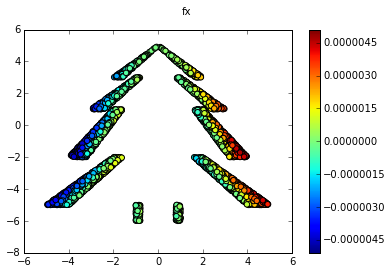

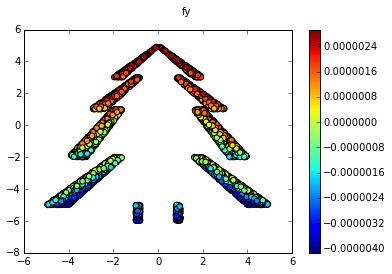

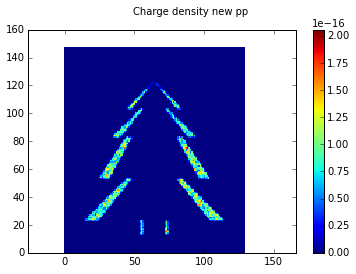

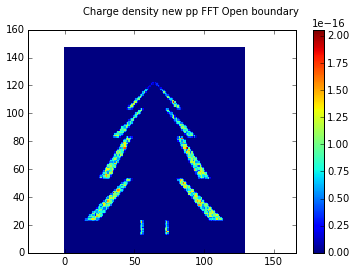

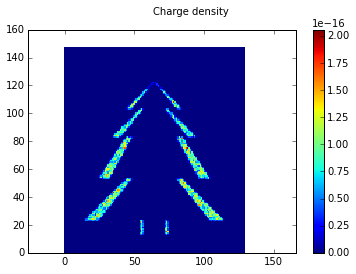

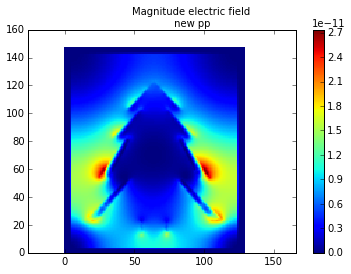

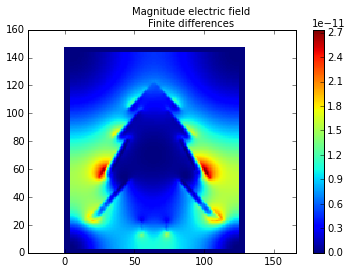

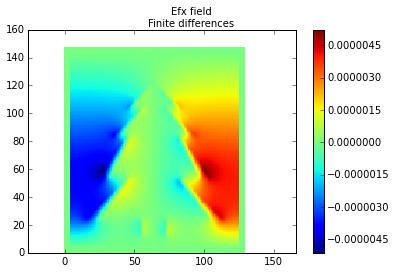

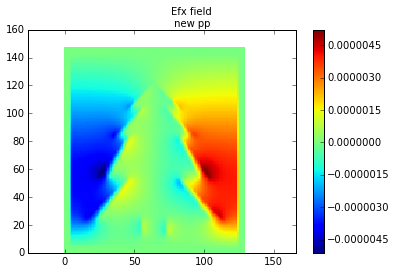

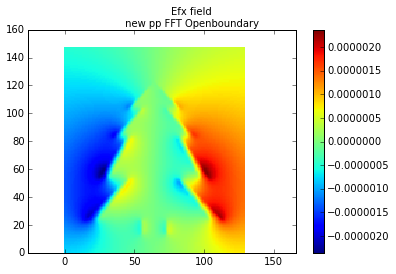

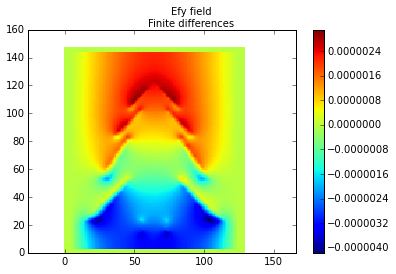

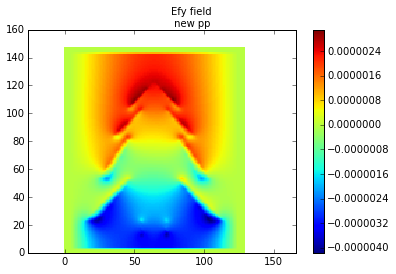

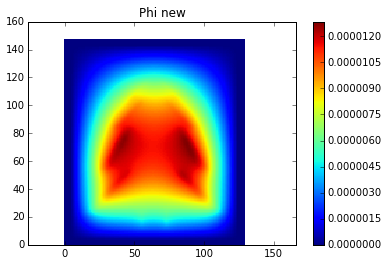

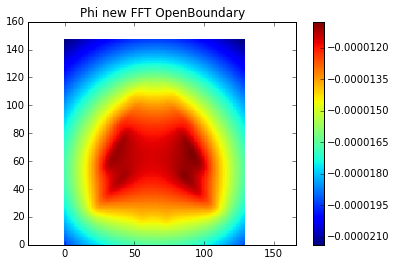

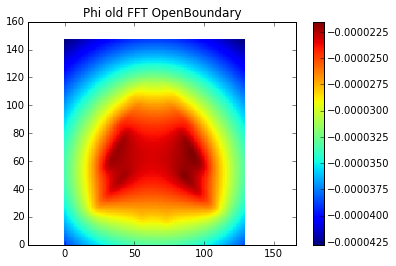

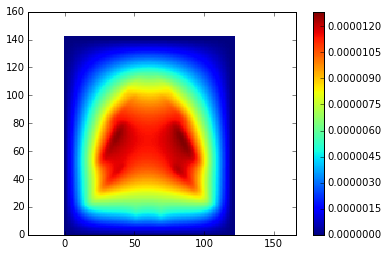

In [5]:
%matplotlib inline
pl.figure()
pl.scatter(x_part, y_part, c=fx, s=30)
pl.suptitle('fx')
pl.colorbar()

pl.figure()
pl.scatter(x_part, y_part, c=fy, s=30)
pl.suptitle('fy')
pl.colorbar()


#pl.close('all')
#pl.figure(1)
##pl.plot(x_tree, y_tree, '-o')
#pl.plot(x_part, y_part, '.g', markersize=2)
#pl.axis('equal')
#pl.suptitle('Macroparticle positions')
#
#pl.figure(2)
#pl.pcolor(picFFTPEC.rho.T)
#pl.axis('equal')
#pl.colorbar()
#pl.suptitle('Charge density')

pl.figure()
pl.pcolor(rho.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density new pp')

pl.figure()
pl.pcolor(rho_FFT.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density new pp FFT Open boundary')

pl.figure()
pl.pcolor(picFDSW.rho.T)
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density')



pl.figure()
pl.pcolor((efx.reshape(mesh.ny, mesh.nx)**2+efy.reshape(mesh.ny, mesh.nx)**2))
pl.axis('equal')
pl.suptitle('Magnitude electric field\n new pp')
pl.colorbar()







pl.figure()
pl.pcolor((picFDSC.efx**2+picFDSC.efy**2).T)
pl.axis('equal')
pl.suptitle('Magnitude electric field\nFinite differences')
pl.colorbar()


pl.figure()
pl.pcolor(picFDSC.efx.T)
pl.axis('equal')
pl.suptitle('Efx field\nFinite differences')
pl.colorbar()
pl.figure()

pl.pcolor(efx.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efx field\n new pp')
pl.colorbar()

pl.figure()
pl.pcolor(efx_FFT.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efx field\n new pp FFT Openboundary')
pl.colorbar()


pl.figure()
pl.pcolor(picFDSC.efy.T)
pl.axis('equal')
pl.suptitle('Efy field\nFinite differences')
pl.colorbar()
pl.figure()

pl.figure()
pl.pcolor(efy.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efy field\n new pp')
pl.colorbar()




pl.figure()
pl.pcolor(phi.reshape(mesh.ny, mesh.nx))
pl.colorbar()
pl.axis('equal')
pl.title('Phi new')
pl.show()

pl.figure()
pl.pcolor(phi_FFT.reshape(mesh.ny, mesh.nx))
pl.colorbar()
pl.axis('equal')
pl.title('Phi new FFT OpenBoundary')
pl.show()

pl.figure()
pl.pcolor(picFFT.phi.T)
pl.colorbar()
pl.title('Phi old FFT OpenBoundary')
pl.axis('equal')



pl.figure()
pl.pcolor(picFDSC.phi.T[3:-2,4:-3])
pl.colorbar()
pl.axis('equal')


#
#pl.figure(203)
#pl.pcolor((picFFT.efx**2+picFFT.efy**2).T)
#pl.axis('equal')
#pl.suptitle('Magnitude electric field - free space')
#pl.colorbar()
#pl.savefig('Xmas_efield_open_boudary.png', dpi=200)


pl.show()

In [6]:
efx.shape
efy.shape

(147, 129)

In [7]:
picFDSC.Nxg, picFDSC.Nyg

(129, 147)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False
(18963,)


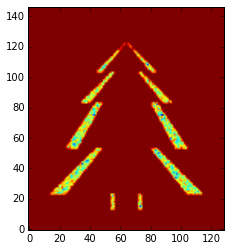

In [8]:
poissonsolver.b.flags
print phi.flags
print phi.shape
pl.imshow(poissonsolver.b.reshape(mesh.nx, mesh.ny).T, origin='lower')

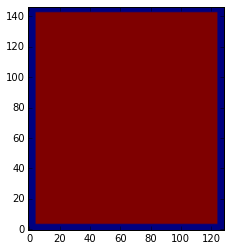

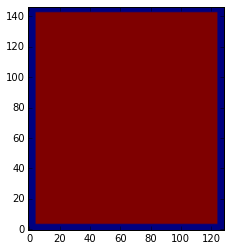

In [9]:
pl.imshow(picFDSC.flag_inside_n.reshape(picFDSC.Nxg, picFDSC.Nyg).T, origin='lower')
pl.show()
pl.figure()
pl.imshow(picFDSW.flag_inside_n.reshape(picFDSW.Nxg, picFDSW.Nyg).T, origin='lower')

In [10]:
mesh_e_fields[0]

array([ -7.74066634e-07,  -7.72980545e-07,  -7.70541292e-07, ...,
         5.08316149e-07,   5.10247056e-07,   5.11181385e-07])